**Event Detection in Social Media Streams**

In [6]:
import nltk
nltk.download('stopwords') # downloading the stopwords corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
!pip install google-api-python-client pandas scikit-learn nltk wordcloud matplotlib seaborn


In [8]:
#-----------------------step 1: importing libraries---------------------------
import pandas as pd # for data handling
import numpy as np # for numerical
import re # for matching patterns, searching and replacing. can group the parts of a pattern.
import matplotlib.pyplot as plt  # for visualization
import seaborn as sns  # for better visualization
from wordcloud import WordCloud # if the frequesncy of a word is greater than it will be representated in greater size. more the frequency greater the size
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer handles tokenizaton, lowercasing, removing stopwords. alos coverts to arrays
from sklearn.cluster import KMeans # to form clusters or say clustering tweets into events
import nltk  # natural language processing. has many features some are: remove the prefix and suffix from sentences and still keep its meaning, categorize words under noun, adjectives, verb,etc, help identify the words such as if the word is a location, thing, person
from nltk.tokenize import word_tokenize # breaking sentences into words
from nltk.corpus import stopwords # remove the irrelevent words such as if, and, are, etc of different language
from collections import Counter # helps in counting the words in a
from scipy.cluster.hierarchy import linkage, fcluster # linkage is used to perform hierarchical clustering.it finds the distance between the d
from scipy.cluster.hierarchy import linkage,fcluster,dendrogram # linkage is used for getting the klinkage matrix that tell us about the clusters. linkage matrix consist of: list of clusters being murged, distance between clusters, how many new data points are now part of the new cluster after the merge. fcluster is used to make a get: like maximum number of clusters,  how clusters are formed and represented after linkage.
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import csv


In [9]:
df=pd.read_csv('/content/GBcomments.csv', on_bad_lines='skip', quoting=csv.QUOTE_MINIMAL,engine='python')
print(df.head())
print(df.columns)
df.rename(columns={'comment_text':'Comment'}, inplace=True)
print(df.columns)

      video_id                                       comment_text  likes  \
0  jt2OHQh0HoQ  It's more accurate to call it the M+ (1000) be...    0.0   
1  jt2OHQh0HoQ              To be there with a samsung phone\n😂😂😂    1.0   
2  jt2OHQh0HoQ  Thank gosh, a place I can watch it without hav...    0.0   
3  jt2OHQh0HoQ  What happened to the home button on the iPhone...    0.0   
4  jt2OHQh0HoQ  Power is the disease.  Care is the cure.  Keep...    0.0   

   replies  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
Index(['video_id', 'comment_text', 'likes', 'replies'], dtype='object')
Index(['video_id', 'Comment', 'likes', 'replies'], dtype='object')


In [10]:
nltk.download('stopwords') # downloading stopwords
nltk.download('punkt_tab') # punkt is used to convert text into sentances and than words
def preprocess_text(text):
  text=str(text).lower() # coverting all the text in the comment to lowercase
  text=re.sub(r"https?://\S+",'',text) # re.sub is used to search a patter. removing the texts. the r represents the the data is raw which means that \ are used as literal characters not the escape characters.http part matches the literal string and s? after that means that s is optional which helps to match with both http:// and https:// . now,  :// also matches the literal characters. than again, \s matches the any non-whitespace  characters. the + is with \s which gives \s+ means typically the rest of the url
  text=re.sub(r"\W", ' ', text) # removing the speacial characters. \W matches any character that is not a word. it includes uppercase, lowercase, digits, u=underscore. it does not involve spaces,punctuation marks, speacial characters, any other character that won't be aphanumeric or underscore. we provided a blank space in ' ' becuse when we remove the punchuations and replace them with a blank space than it helps from getting the text from being corelated to each other
  text=re.sub(r"\s+",' ', text) # removing the extra spaces
  words=word_tokenize(text) # tokenizing. this involves  splitting text into individual words.
  words=[ word for word in words if word not in stopwords.words('english')] #Remove stopwords. stopwords(is, in, and, etc) carry very little meaning.
  return' '.join(words)
df["Cleaned_Comment"]=df['Comment'].apply(preprocess_text) # calling the function to clean the Comments
print(df[["Comment", "Cleaned_Comment"]].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                             Comment  \
0  It's more accurate to call it the M+ (1000) be...   
1              To be there with a samsung phone\n😂😂😂   
2  Thank gosh, a place I can watch it without hav...   
3  What happened to the home button on the iPhone...   
4  Power is the disease.  Care is the cure.  Keep...   

                                     Cleaned_Comment  
0       accurate call 1000 price closer calling x 10  
1                                    samsung phone n  
2  thank gosh place watch without hd speed suppor...  
3  happened home button iphone x cough copying sa...  
4  power disease care cure keep caring others bes...  


In [11]:
# now we need to convert texts into numbers( TF-IDF vectorization)
vectorizer=TfidfVectorizer(max_features=1000) # we are converting the texts into the matrixes to find how imaportant, rare the word is. the matrix consists of the corresponding TF-IDF score
x= vectorizer.fit_transform(df['Cleaned_Comment']) # converting the text data into numarical values
print(x.shape)

(19729, 1000)


In [12]:
# we will be applying k mean clustering
number_of_clusters=5 # limiting the number of clusters i want
kmeans=KMeans(n_clusters=number_of_clusters, random_state=42)
df['KMeans_Cluster']=kmeans.fit_predict(x)
print(df[["Comment", "KMeans_Cluster"]].head())

                                             Comment  KMeans_Cluster
0  It's more accurate to call it the M+ (1000) be...               4
1              To be there with a samsung phone\n😂😂😂               4
2  Thank gosh, a place I can watch it without hav...               4
3  What happened to the home button on the iPhone...               4
4  Power is the disease.  Care is the cure.  Keep...               4


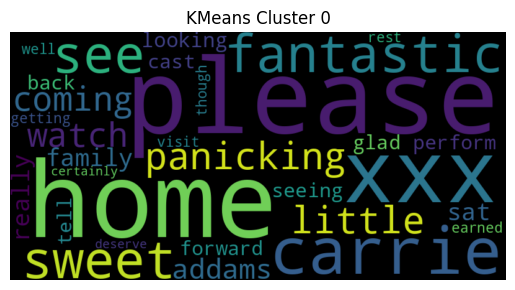

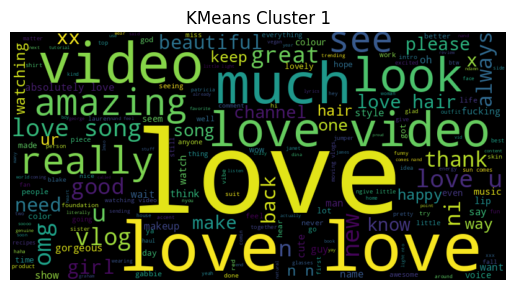

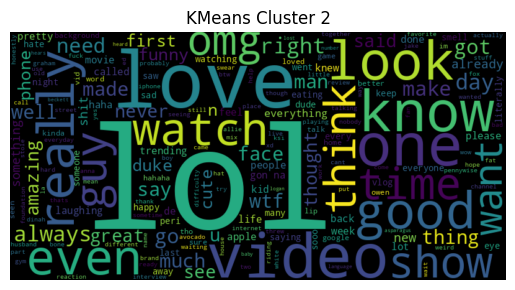

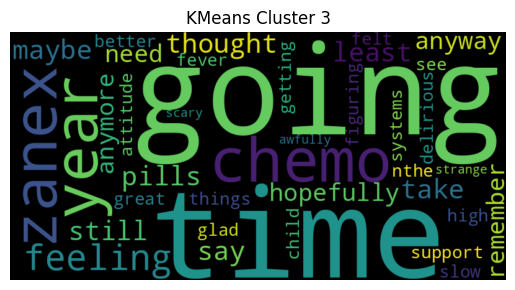

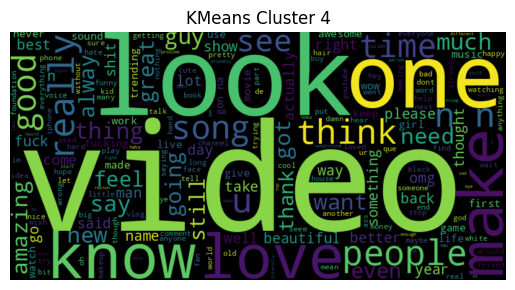

In [13]:
# we will be Visualize Clusters with Word Clouds. a word cloud is a visual representation of text data based on the word size and its frequencies
for cluster in range(number_of_clusters):
  cluster_comments= df[df['KMeans_Cluster']==cluster]['Cleaned_Comment'] # df['KMeans_Cluster]==cluster creates a series of True and False which checks if the each row in Cluster matches the cluster. df[df['Cluster']==cluster] will return new dataframe which will only contains the rows where the Cluster column matches particular cluster. [cleaned_Comment] with the others will contain only the cleaned comments that will belong to a particualr cluster
  text=' '.join(cluster_comments) # the comments that are similar will form a string
  wordcloud=WordCloud(width=800, height=400).generate(text) # .generate(text) is used as it takes the text data and than gives it to the wordcloud for the visual representation
  plt.imshow(wordcloud, interpolation='bilinear') # interpolation is used to define the color of th pixels. billinear uses closest 2X2 matrix. it first perfoms the linear and than other directions. this results the smoother image as comparision to the naerest neighbor interpolation
  plt.axis("off")
  plt.title(f"KMeans Cluster {cluster}")
  plt.show()
  # this helped us to see the most common words in each cluster

In [14]:
# we gotta identify the event in the clusters
for cluster in range (number_of_clusters):
  cluster_comments=df[df['KMeans_Cluster']==cluster]['Cleaned_Comment']
  all_words=' '.join(cluster_comments).split() # taking the cluster_comments and and join them in a single string with space. from here the split splits the string at whitespaces, tabs, newlines and return a list of words
  common_words=Counter(all_words).most_common(10) # 10 is to get the most common 10 words
  print(f"Cluster {cluster} top words: {common_words}")

Cluster 0 top words: [('home', 3), ('please', 3), ('xxx', 2), ('carrie', 1), ('fantastic', 1), ('see', 1), ('sweet', 1), ('also', 1), ('panicking', 1), ('little', 1)]
Cluster 1 top words: [('love', 1467), ('much', 116), ('videos', 113), ('video', 84), ('n', 72), ('u', 66), ('song', 61), ('look', 53), ('would', 49), ('really', 45)]
Cluster 2 top words: [('lol', 394), ('like', 40), ('love', 36), ('one', 19), ('know', 18), ('get', 18), ('really', 14), ('video', 14), ('even', 13), ('good', 13)]
Cluster 3 top words: [('going', 3), ('time', 3), ('chemo', 2), ('zanex', 2), ('year', 2), ('feeling', 2), ('thought', 1), ('say', 1), ('would', 1), ('take', 1)]
Cluster 4 top words: [('like', 1977), ('n', 1804), ('video', 920), ('one', 852), ('know', 779), ('good', 763), ('get', 757), ('would', 719), ('really', 696), ('love', 694)]


In [15]:
# we will detect the event
event_keywords=["earthquake", "protest", "accident", "breaking", "viral", "trending"]
def detect_events(cluster_comments):
  for keyword in event_keywords:
    if keyword in cluster_comments:
      return True
  return False
df['is event']=df['Cleaned_Comment'].apply(detect_events)
print(df[df['is event'] == True]) # printing the detected event

          video_id                                            Comment  likes  \
100    YPVcg45W0z4  Emma is 3rd on the trending page at the time o...    0.0   
111    YPVcg45W0z4     Do you know that your number 3 on trending👏🏻👏🏻    0.0   
174    YPVcg45W0z4                               Number 3 on trending    0.0   
177    YPVcg45W0z4                  3rd on trending well done Emma~!!    0.0   
194    YPVcg45W0z4                           Please get off trending.    1.0   
...            ...                                                ...    ...   
19604  T_PuZBdT2iM  Hahaha ok this was worth it. Sometimes trendin...    0.0   
19619  T_PuZBdT2iM                        Why is this trending?!? lol    0.0   
19622  T_PuZBdT2iM                                          trending!    0.0   
19626  T_PuZBdT2iM           Why do these always get fucking trending    0.0   
19642  T_PuZBdT2iM                        #45 on trending, huh? Neat.    0.0   

       replies                         

In [16]:
# to see hpow well the clustering is
from sklearn.metrics import silhouette_score # if the score is near 1 than clustering is good. if its near than it is bad
silhouette_avg= silhouette_score(x, df["KMeans_Cluster"])
print(f"silhouette score:{silhouette_avg}")

silhouette score:0.03438157663722849


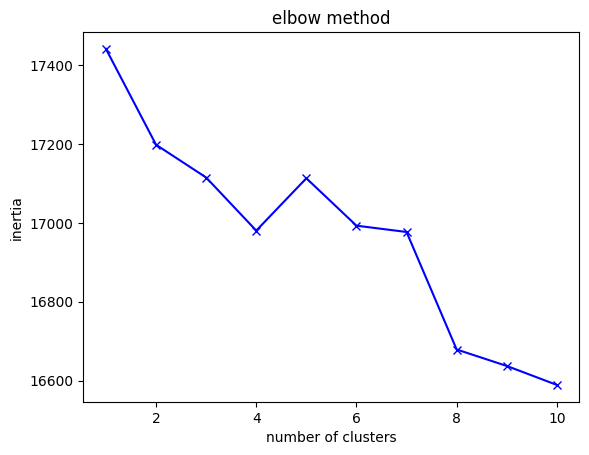

In [17]:
# elbow mwthod ( for checking how many clusters should be made)
inertia=[]
K=range(1,11)
for k in K:
  kmeans=KMeans(n_clusters=k,random_state=42)
  kmeans.fit(x)
  inertia.append(kmeans.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.title("elbow method")
plt.show()

In [21]:
from sklearn.metrics import davies_bouldin_score # if the score is less it means good
db_score=davies_bouldin_score(x.toarray(), df["KMeans_Cluster"])
print(f"davies bouldin index: {db_score}")

davies bouldin index: 2.622336117847413


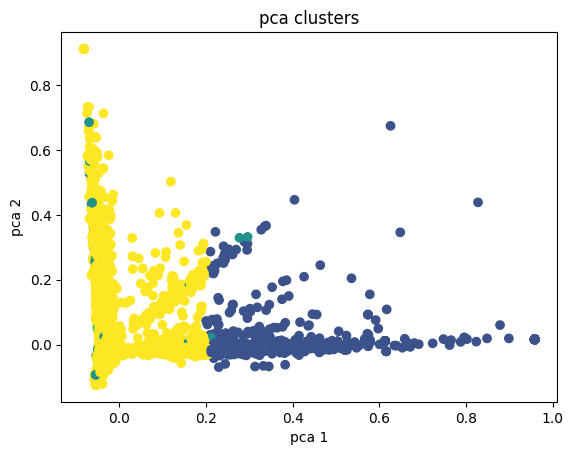

In [22]:
# visual inspection to see how far the clusters are: (if the silhouette score is less yet the number of cluster needed is good than one of the reasons could be that distance between the clusters colud be less)
# PCA (principal component analysis) ot t-SNE (t-distribution stochastic neighbor embedding) is used to see how well- separated clusters are
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
reduced_data=pca.fit_transform(x.toarray())
plt.scatter(reduced_data[:,0], reduced_data[:, 1], c=df["KMeans_Cluster"], cmap="viridis", marker="o")
plt.title("pca clusters")
plt.xlabel("pca 1")
plt.ylabel("pca 2")
plt.show()